In [65]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [5]:
np.random.seed(42)
tf.random.set_seed(42)


In [7]:
#input data extracting with haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_faces_opencv(input_dir, output_dir, size=(224, 224)):
    os.makedirs(output_dir, exist_ok=True)
    for person in os.listdir(input_dir):
        person_dir = os.path.join(input_dir, person)
        output_person_dir = os.path.join(output_dir, person)
        os.makedirs(output_person_dir, exist_ok=True)

        for image_name in os.listdir(person_dir):
            img_path = os.path.join(person_dir, image_name)
            try:
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
                for (x, y, w, h) in faces:
                    face = img[y:y+h, x:x+w]
                    face_resized = cv2.resize(face, size)
                    save_path = os.path.join(output_person_dir, image_name)
                    cv2.imwrite(save_path, face_resized)
                    break
            except Exception as e:
                print(f"Failed on {img_path}: {e}")

crop_faces_opencv("raw_imgs", "cropped_imgs")


In [9]:
#data path
path = "cropped_imgs"
classes = ['Ahsam', 'Maruf', 'Saiba', 'Shusmita']
classLabel = {cls: idx for idx, cls in enumerate(classes)}
max_images_per_class = 345
image_size = 224


In [33]:
#preprocessing
data = []
for cls in classes:
    class_dir = os.path.join(path, cls)
    count = 0
    for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {cls}"):
        if count >= max_images_per_class:
            break
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append((img, classLabel[cls]))
        count += 1

print(f"Total samples: {len(data)}")


Loading Shusmita: 100%|█████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 746.72it/s]

Total samples: 1380


In [35]:
np.random.shuffle(data)

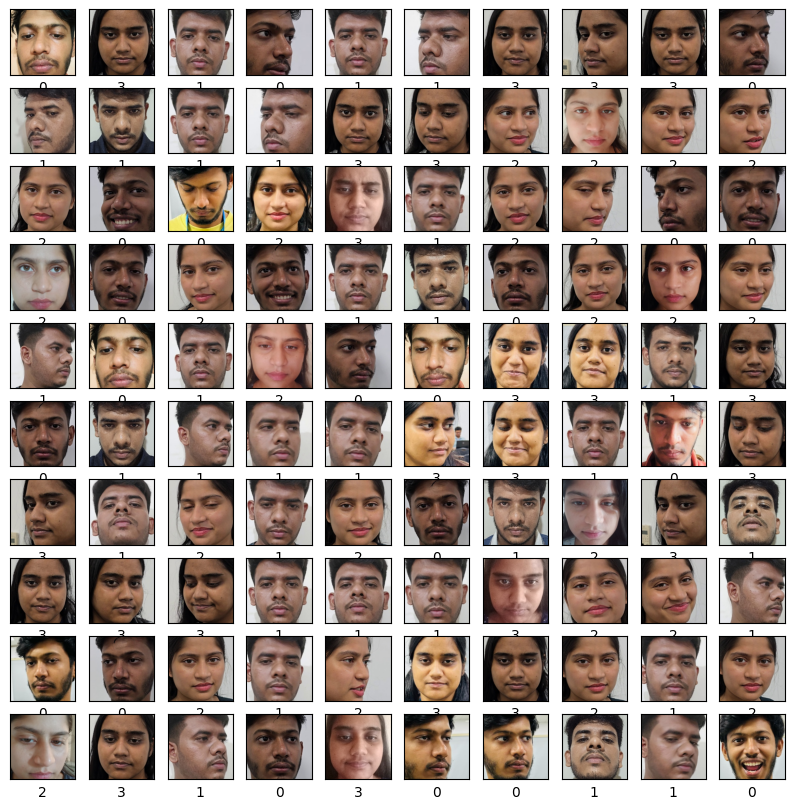

In [37]:
#visualization
plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(data[i][0])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(data[i][1])
plt.show()


In [39]:
X, y = zip(*data)
X = np.array(X, dtype=np.float32)
y = np.array(y)
y_cat = to_categorical(y, num_classes=len(classes))

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)


In [57]:
#augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    channel_shift_range=0.1,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

In [59]:
val_datagen = ImageDataGenerator(rescale=1./255)


In [61]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16, shuffle=False)


In [67]:
#CNN architecture
input_shape = (224, 224, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

for layer in base_model.layers:
    layer.trainable = True  
    
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation='softmax')(x)


C:\Users\Asus\AppData\Local\Temp\ipykernel_2156\2768072693.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))


In [69]:
model = Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 18,347,972 (69.99 MB)

 Trainable params: 18,313,860 (69.86 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [71]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [73]:
#training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4085 - loss: 2.7634 - val_accuracy: 0.2174 - val_loss: 4.5762
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.7510 - loss: 1.1896 - val_accuracy: 0.2283 - val_loss: 5.7984
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8728 - loss: 0.8861 - val_accuracy: 0.2391 - val_loss: 6.9494
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9142 - loss: 0.7854 - val_accuracy: 0.2754 - val_loss: 6.2520
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9414 - loss: 0.7110 - val_accuracy: 0.6268 - val_loss: 2.2999
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9505 - loss: 0.7025 - val_accuracy: 0.8080 - val_loss: 1.1381
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9569 - loss: 0.6502 - val_accuracy: 0.6268 - val_loss: 2.4960
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.9624 - loss: 0.6590 - val_accuracy: 0.9203 - v

In [75]:
model.save("face_recognition_model.h5")

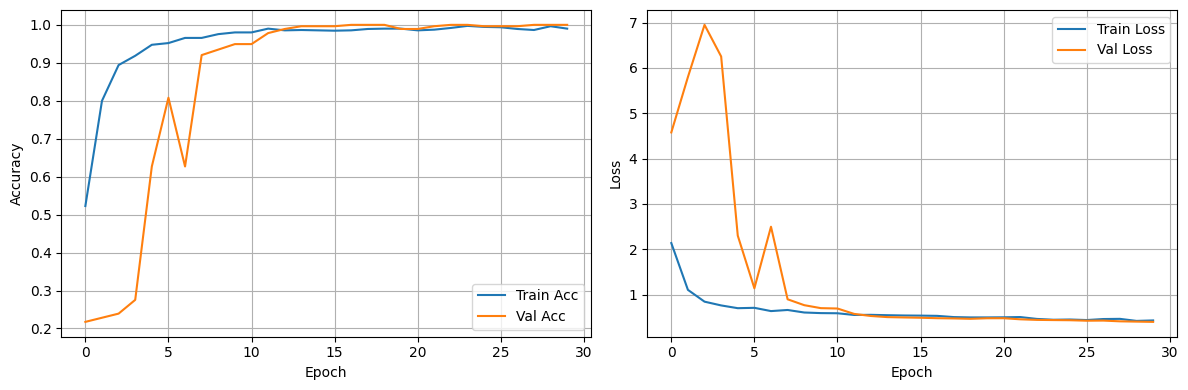

In [77]:
#accuracy and loss plotting
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
